In [128]:
import praw
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
import re
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline()
import contractions
import pickle

In [129]:

'''
[R]ediquette has only 17 data points which means that the number of data in that subcategory is only 17. We can expect false positives and false negatives in this category
Need to confirm via confusion matrix.
'''
data = pd.read_csv('../Precog_task/Reddit-ML-model(2).csv')
data['url'][3]

'https://www.reddit.com/r/india/comments/cu1xn4/randians_what_are_you_too_afraid_to_ask/'

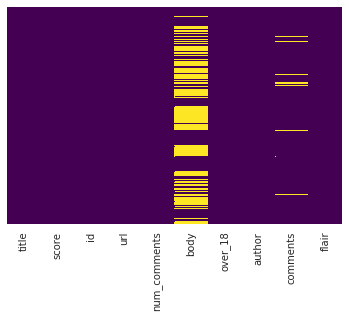

In [130]:

# Heatmap to locate missing data

sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

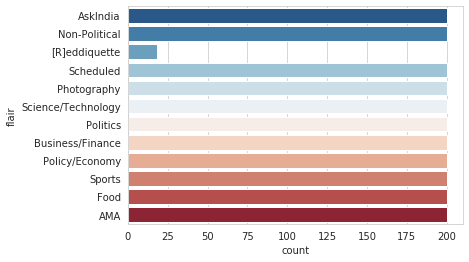

In [131]:
# Checking data

sns.set_style('whitegrid')
sns.countplot(y='flair',data=data,palette='RdBu_r',orient='v')

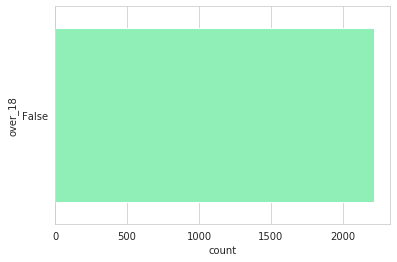

In [132]:
# Checking data of over_18

sns.set_style('whitegrid')
sns.countplot(y='over_18',data=data,palette='rainbow',orient='v')

In [133]:
# interactive plot for number of comments using cufflinks and pandas

data['num_comments'].iplot(kind='hist',bins=30,color='green')

In [134]:
# Seeing the format of data recieved from API

data['body'][0]

'**Re-posting here because of lack of activity in /r/AskIndia**\n\nHello,\n\nLast year I took a Term policy from ICICI Prudential. I took this policy with the intention of "Insurance" rather than "Investment".\n\nSo as per this policy: 1) I will be paying Rs. 14000~ for 30 years. The Sum Assured is Rs. 325000.\n\n2) At the end of Premium Paying term, company will pay Sum Assured, plus revisionary and terminal bonuses if any.\n\n3) If I die within Premium paying term (30 yrs), company will pay "twice" the Sum assured, plus revisionary and terminal bonuses if any.\n\n4) If I die after the Premium paying term or if I turn 100, company will pay the Sum assured (without revisionary and bonuses).\n\nQuestions:\n\n1) The Sum assured is less than the total premium I ll pay. Is it normal for a Term policy?\n\n2) If I die during Premium paying term, are the returns sufficient in comparison to the amount I pay?\n\n3) Points 4 and 2 seems to be confusing. Are they going to pay me twice?\n\nPlease 

In [135]:
wnl = WordNetLemmatizer()
remove =set(stopwords.words('english'))
def edit(words):
    words =str(words)
    words=re.sub('([.,////])',' ',words)
    words=re.sub('\[.*?\]', '', words)
    words = words.replace('\n', ' ')
    words = contractions.fix(words)
    word_list = nltk.word_tokenize(re.sub(r'([^a-z A-Z])', '', words.lower()))
    comment = ' '.join([wnl.lemmatize(w) for w in word_list if w not in remove])
    return comment

In [136]:
def edit2(words):
    words=str(words)
    if 'https://www.reddit.com/r/india/comments/' in words:
        count =0
        s=''
        for i in range(len(words)):
            if words[i]=='/':
                count+=1
            elif count==7:
                s+=words[i]
        lis = s.split('_')
        t=' '.join(word for word in lis )
        return str(t)
    else: 
        return words

In [137]:
data['title'] = data['title'].apply(edit)
data['body'] = data['body'].apply(edit)
data['comments'] = data['comments'].apply(edit)

In [138]:
data['url']=data['url'].apply(edit2)

In [139]:
data['url'][1]

'somebody want to kill my full family what to do'

### Applying Machine Learning Models to the data

In [140]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
# get_text_data = FunctionTransformer(lambda x: x['total'], validate=False)
# get_numeric_data = FunctionTransformer(lambda x: x[['num_comments','score']], validate=False)
def logisticalRegression(X,y):
    from sklearn.linear_model import LogisticRegression
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
#     logreg = Pipeline([
#     ('features', FeatureUnion([
#             ('numeric_features', Pipeline([
#                 ('selector', get_numeric_data)
#             ])),
#              ('text_features', Pipeline([
#                 ('selector', get_text_data),
#                 ('vec', CountVectorizer()),('tfidf', TfidfTransformer())
#             ]))
#          ])),
#     ('clf',LogisticRegression(C=1,penalty='l1'))
# ])
    logreg = make_pipeline(CountVectorizer(),TfidfTransformer(),LogisticRegression(C=1,penalty='l1'))#l2 penalty is significantly worse
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
#     from sklearn.model_selection import GridSearchCV
#     param_grid = {'logisticregression__C': [1,10,100,1000,1e4,1e5],
#                  'logisticregression__penalty': ['l1','l2']}
#     grid = GridSearchCV(logreg, param_grid, cv=5)
#     grid.fit(X_train, y_train)

#     print("Best cross-validation score:",grid.best_score_)
#     print("Best parameters: ", grid.best_params_)
#     print("Best estimator: ", grid.best_estimator_)
    
    y_pred = logreg.predict(X_test)
    print('test accuracy',accuracy_score(y_pred, y_test))
    print('train accuracy',logreg.score(X_train, y_train))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test, y_pred))
    pickle.dump(logreg, open("model(2).pkl","wb"))

In [141]:
data['total']=data['title']+' '+data['comments']+ ' ' + data['body'] + ' '+data['url']
X=data['total']
y=data['flair']
logisticalRegression(X,y)

/home/jushaan/Downloads/yes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/home/jushaan/Downloads/yes/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



test accuracy 0.8513513513513513
train accuracy 0.8653350515463918
[[51  0  1  2  1  0  1  0  0  1  0  0]
 [ 0 42  0  3  9  0  1  0  0  3  1  0]
 [ 0  0 45  0  3  1  6  1  0  5  0  0]
 [ 0  0  0 52  2  1  0  2  0  0  1  0]
 [ 0  1  3  4 53  0  0  2  0  1  0  0]
 [ 0  1  0  2  2 60  0  0  0  0  0  0]
 [ 0  0  5  0  2  0 48  5  0  1  0  0]
 [ 0  0  0  0  0  0  0 53  0  1  2  0]
 [ 0  0  0  0  2  0  0  1 45  1  1  0]
 [ 0  2  5  0  1  0  4  0  0 59  0  0]
 [ 0  0  0  0  2  0  0  0  0  0 56  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  3]]
                    precision    recall  f1-score   support

               AMA       1.00      0.89      0.94        57
          AskIndia       0.91      0.71      0.80        59
  Business/Finance       0.76      0.74      0.75        61
              Food       0.83      0.90      0.86        58
     Non-Political       0.66      0.83      0.74        64
       Photography       0.97      0.92      0.94        65
    Policy/Economy       0.80      0.79    

In [39]:
def nb_classifier(X,y):
  
    from sklearn.naive_bayes import MultinomialNB
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)

    nb = make_pipeline(CountVectorizer(),TfidfTransformer(),MultinomialNB(alpha=2))
    nb.fit(X_train, y_train)
#     from sklearn.model_selection import GridSearchCV
#     param_grid = {'multinomialnb__alpha': [1,2,10,5]}
#     grid = GridSearchCV(nb, param_grid, cv=5)
#     grid.fit(X_train, y_train)

#     print("Best cross-validation score:",grid.best_score_)
#     print("Best parameters: ", grid.best_params_)
#     print("Best estimator: ", grid.best_estimator_)
    y_pred = nb.predict(X_test)
    print('test accuracy',accuracy_score(y_pred, y_test))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test, y_pred))

In [40]:
X=data['comments']
y=data['flair']
nb_classifier(X,y)

test accuracy 0.47297297297297297
[[46  1  1  1  2  0  3  3  0  0  0  0]
 [32  5  2  7  3  1  5  1  0  0  3  0]
 [15  1  7  0  3  0 27  4  3  1  0  0]
 [10  1  0 35  2  0  4  5  1  0  0  0]
 [22  3  1  6  7  1  8  8  5  1  2  0]
 [27  1  0  2  5 27  0  3  0  0  0  0]
 [ 7  0  1  0  2  0 42  7  1  1  0  0]
 [ 2  0  0  0  0  0  3 46  2  1  2  0]
 [ 6  1  0  0  1  0  6  6 27  0  3  0]
 [18  2  2  1  5  0  8  8  1 25  1  0]
 [ 6  0  0  1  2  0  0  0  1  0 48  0]
 [ 3  0  0  0  0  0  1  2  0  0  0  0]]
                    precision    recall  f1-score   support

               AMA       0.24      0.81      0.37        57
          AskIndia       0.33      0.08      0.14        59
  Business/Finance       0.50      0.11      0.19        61
              Food       0.66      0.60      0.63        58
     Non-Political       0.22      0.11      0.15        64
       Photography       0.93      0.42      0.57        65
    Policy/Economy       0.39      0.69      0.50        61
          Politi

/home/jushaan/Downloads/yes/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [41]:
def svm(X,y):
  
    from sklearn.linear_model import SGDClassifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)

    
    sgd = make_pipeline(CountVectorizer(),TfidfTransformer(),SGDClassifier(alpha=0.001,
                               penalty='elasticnet'))
#     from sklearn.model_selection import GridSearchCV
#     param_grid = {'sgdclassifier__alpha': [0.001],
#                  'sgdclassifier__penalty': ['elasticnet']}
#     grid = GridSearchCV(sgd, param_grid, cv=5,verbose = 3)
#     grid.fit(X_train, y_train)

#     print("Best cross-validation score:",grid.best_score_)
#     print("Best parameters: ", grid.best_params_)
#     print("Best estimator: ", grid.best_estimator_)
    
    
    
    sgd.fit(X_train, y_train)

    
    y_pred = sgd.predict(X_test)

    print('test accuracy',accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))

In [47]:
X=data['comments']
y=data['flair']
svm(X,y)

test accuracy 0.6141141141141141
                    precision    recall  f1-score   support

               AMA       0.73      0.84      0.78        57
          AskIndia       0.24      0.07      0.11        59
  Business/Finance       0.62      0.46      0.53        61
              Food       0.60      0.86      0.70        58
     Non-Political       0.33      0.09      0.15        64
       Photography       0.70      0.72      0.71        65
    Policy/Economy       0.59      0.64      0.61        61
          Politics       0.72      0.84      0.78        56
         Scheduled       0.62      0.72      0.67        50
Science/Technology       0.46      0.66      0.54        71
            Sports       0.73      0.91      0.81        58
     [R]eddiquette       0.80      0.67      0.73         6

          accuracy                           0.61       666
         macro avg       0.59      0.62      0.59       666
      weighted avg       0.57      0.61      0.58       666



In [48]:
def randomf(X,y):
  
    from sklearn.ensemble import RandomForestClassifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
    pipeline = make_pipeline(CountVectorizer(),TfidfTransformer(), RandomForestClassifier(criterion = "gini",n_estimators=1000))
#    print(sorted(pipeline.get_params().keys()))
#     from sklearn.model_selection import GridSearchCV
#     param_grid = { 
#     'randomforestclassifier__n_estimators': [1000, 1500,500],
#     'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']}
#     grid = GridSearchCV(pipeline, param_grid, cv=5)
#     grid.fit(X_train, y_train)

#     print("Best cross-validation score: {}".format(grid.best_score_))
#     print("Best parameters: ", grid.best_params_)
#     print("Best estimator: ", grid.best_estimator_)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print('accuracy ',accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))

In [54]:
X=data['url']
y=data['flair']
randomf(X,y)

accuracy  0.4339339339339339
                    precision    recall  f1-score   support

               AMA       0.57      0.40      0.47        57
          AskIndia       0.37      0.64      0.47        59
  Business/Finance       0.33      0.38      0.35        61
              Food       0.64      0.31      0.42        58
     Non-Political       0.69      0.56      0.62        64
       Photography       0.38      0.37      0.37        65
    Policy/Economy       0.37      0.41      0.39        61
          Politics       0.44      0.55      0.49        56
         Scheduled       0.56      0.40      0.47        50
Science/Technology       0.38      0.35      0.36        71
            Sports       0.38      0.45      0.41        58
     [R]eddiquette       0.00      0.00      0.00         6

          accuracy                           0.43       666
         macro avg       0.43      0.40      0.40       666
      weighted avg       0.46      0.43      0.43       666



In [59]:
def passAgg(X,y):
    
    from sklearn.linear_model import PassiveAggressiveClassifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)

    passiv = make_pipeline(CountVectorizer(),TfidfTransformer(),  PassiveAggressiveClassifier())
    passiv.fit(X_train, y_train)

    y_pred = passiv.predict(X_test)

    print('accuracy',accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))

In [65]:
X=data['comments']
y=data['flair']
passAgg(X,y)

accuracy 0.6141141141141141
                    precision    recall  f1-score   support

               AMA       0.84      0.75      0.80        57
          AskIndia       0.44      0.39      0.41        59
  Business/Finance       0.51      0.56      0.53        61
              Food       0.69      0.72      0.71        58
     Non-Political       0.27      0.11      0.16        64
       Photography       0.52      0.72      0.60        65
    Policy/Economy       0.65      0.56      0.60        61
          Politics       0.65      0.86      0.74        56
         Scheduled       0.66      0.76      0.70        50
Science/Technology       0.56      0.51      0.53        71
            Sports       0.82      0.91      0.86        58
     [R]eddiquette       0.80      0.67      0.73         6

          accuracy                           0.61       666
         macro avg       0.62      0.63      0.61       666
      weighted avg       0.60      0.61      0.60       666

